# Predicting The Stock Market

In this project, we'll work with the sphist.csv file containing index prices.

Each row in the file contains a daily record of the price of the [S&P500](https://en.wikipedia.org/wiki/S%26P_500_Index) Index from 1950 to 2015.

The columns in the data-set are outlined below:

- Date: The date of the record.
- Open: The opening price of the day (when trading starts).
- High: The highest trade price during the day.
- Low: The lowest trade price during the day.
- Close: The closing price for the day (when trading is finished).
- Volume: The number of shares traded.
- Adj Close: The daily closing price, adjusted retroactively to include any corporate actions.

We'll be using this dataset to develop a predictive model. The model will be trained on data from 1950-2012, and then we'll try and use it to make predictions for 2013-2015. The sphist.csv can be found in the repository here.

To start with, we will import the libraries we need and then read in the sphist.csv file.

__Note: You shouldn't make trades with any models developed in this project. Trading stocks has risks, and nothing in this project constitutes stock trading advice.__

In [1]:
#import recessary libraries

import pandas as pd
import numpy as np
import datetime as dt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.style as style

In [2]:
%matplotlib inline
style.use('fivethirtyeight')

In [3]:
data = pd.read_csv('sphist.csv')
pd.options.display.max_columns = 99
data.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883


In [4]:
data.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16590 entries, 0 to 16589
Data columns (total 7 columns):
Date         16590 non-null object
Open         16590 non-null float64
High         16590 non-null float64
Low          16590 non-null float64
Close        16590 non-null float64
Volume       16590 non-null float64
Adj Close    16590 non-null float64
dtypes: float64(6), object(1)
memory usage: 907.3+ KB


__Convert the Date column to a datetime object to assist with analysis__

In [6]:
data['Date'] = pd.to_datetime(data['Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16590 entries, 0 to 16589
Data columns (total 7 columns):
Date         16590 non-null datetime64[ns]
Open         16590 non-null float64
High         16590 non-null float64
Low          16590 non-null float64
Close        16590 non-null float64
Volume       16590 non-null float64
Adj Close    16590 non-null float64
dtypes: datetime64[ns](1), float64(6)
memory usage: 907.3 KB


In [7]:
#Sort dataframe in ascending order of Date column

data = data.sort_values(by = 'Date')
data = data.reset_index(drop=True)
data.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,1950-01-03,16.66,16.66,16.66,16.66,1260000.0,16.66
1,1950-01-04,16.85,16.85,16.85,16.85,1890000.0,16.85
2,1950-01-05,16.93,16.93,16.93,16.93,2550000.0,16.93
3,1950-01-06,16.98,16.98,16.98,16.98,2010000.0,16.98
4,1950-01-09,17.08,17.08,17.08,17.08,2520000.0,17.08


In [8]:
#Distribution of the target column
data['Close'].describe()

count    16590.000000
mean       482.692491
std        555.007904
min         16.660000
25%         83.860001
50%        144.264999
75%        950.797500
max       2130.820068
Name: Close, dtype: float64

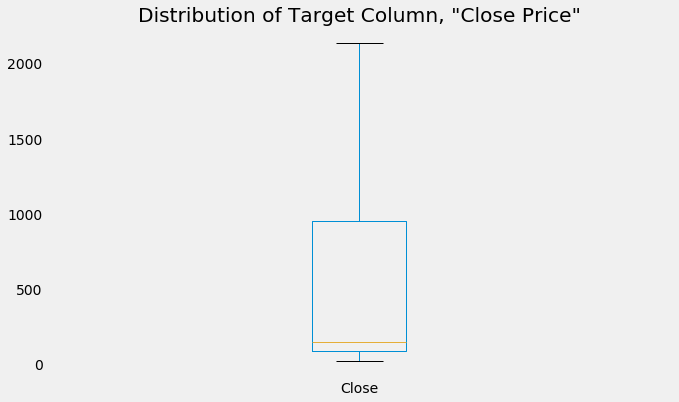

In [9]:
#Visualize Distribution
data.plot(y = 'Close',
          kind = 'box',
          figsize=(10,6), 
          title='Distribution of Target Column, "Close Price"'
            )
plt.grid()
plt.show()

## Generating new indicators

In a typical machine learning project, we might treat each row as independent.

Stock market data however is sequential, and each observation comes a day after the previous observation. Thus, __the observations are not all independent,__ and we can't treat them as such.

This means we have to be extra careful to not inject "future" knowledge into past rows when we do training and prediction. Injecting future knowledge would make our model look good when we're training and testing it, but would cause it to fail when applied in the real world. This is how many algorithmic traders lose money.

To account for this, we'll instead generate 6 indicators for each row.

The indicators will measure:

- average price for the past 5 days
- average price for the past 30 days
- average price for the past 100 days
- standard deviation for price over the past 5 days
- standard deviation for price over the past 30 days
- standard deviation for price over the past 100 days

Each of these 6 indicators will be added on as columns to the 'data' dataframe.

The rolling function, which is a time series tool from pandas, will be used to perform most of the computation for us. The windows parameter will be used to specify the number of days in the past.

The Close column in the dataframe refers to the closing price for the day, so we'll use this to calculate the necessary indicators.

In [10]:
# Calculating the means:
mean_5 = data['Close'].rolling(window=5).mean().shift()
mean_30 = data['Close'].rolling(window=30).mean().shift()
mean_100 = data['Close'].rolling(window=100).mean().shift()

# Calculating the standard deviations:
std_5 = data['Close'].rolling(window=5).std().shift()
std_30 = data['Close'].rolling(window=30).std().shift()
std_100 = data['Close'].rolling(window=100).std().shift()

_Since the rolling mean/std used the current day's price, we had to reindex the resulting series to shift all the values "forward" one day._

_For example, the rolling mean calculated for 1950-01-03 needed to be assigned to 1950-01-04, etc. We did this using the shift method above._

_Next, we'll add these indicators into the 'data' dataframe._

In [11]:
data['mean_5'] = mean_5
data['mean_30'] = mean_30
data['mean_100'] = mean_100
data['std_5'] = std_5
data['std_30'] = std_30
data['std_100'] = std_100

In [12]:
data.head(10)

,Date,Open,High,Low,Close,Volume,Adj Close,mean_5,mean_30,mean_100,std_5,std_30,std_100
0,1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000.0,16.660000,NaN,NaN,NaN,NaN,NaN,NaN
1,1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000.0,16.850000,NaN,NaN,NaN,NaN,NaN,NaN
2,1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000.0,16.930000,NaN,NaN,NaN,NaN,NaN,NaN
3,1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000.0,16.980000,NaN,NaN,NaN,NaN,NaN,NaN
4,1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000.0,17.080000,NaN,NaN,NaN,NaN,NaN,NaN
5,1950-01-10,17.030001,17.030001,17.030001,17.030001,2160000.0,17.030001,16.900,NaN,NaN,0.157956,NaN,NaN
6,1950-01-11,17.090000,17.090000,17.090000,17.090000,2630000.0,17.090000,16.974,NaN,NaN,0.089051,NaN,NaN
7,1950-01-12,16.760000,16.760000,16.760000,16.760000,2970000.0,16.760000,17.022,NaN,NaN,0.067602,NaN,NaN
8,1950-01-13,16.670000,16.670000,16.670000,16.670000,3330000.0,16.670000,16.988,NaN,NaN,0.134796,NaN,NaN
9,1950-01-16,16.719999,16.719999,16.719999,16.719999,1460000.0,16.719999,16.926,NaN,NaN,0.196545,NaN,NaN


In [13]:
data.tail(10)

,Date,Open,High,Low,Close,Volume,Adj Close,mean_5,mean_30,mean_100,std_5,std_30,std_100
16580,2015-11-23,2089.409912,2095.610107,2081.389893,2086.590088,3.587980e+09,2086.590088,2071.523974,2061.892989,2033.864700,18.246940,32.699325,68.725388
16581,2015-11-24,2084.419922,2094.120117,2070.290039,2089.139893,3.884930e+09,2089.139893,2078.204004,2064.197327,2033.962800,15.807754,31.885833,68.794233
16582,2015-11-25,2089.300049,2093.000000,2086.300049,2088.870117,2.852940e+09,2088.870117,2085.943994,2067.045658,2034.166599,3.491188,30.058610,68.928415
16583,2015-11-27,2088.820068,2093.290039,2084.129883,2090.110107,1.466840e+09,2090.110107,2087.002002,2070.199996,2034.241899,3.395982,26.960525,68.984560
16584,2015-11-30,2090.949951,2093.810059,2080.409912,2080.409912,4.245030e+09,2080.409912,2088.776025,2072.408333,2034.676200,1.309055,25.718597,69.200030
16585,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883,2087.024023,2073.984998,2034.967198,3.916109,24.654181,69.331744
16586,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010,2090.231982,2076.283993,2035.227296,7.956808,23.970453,69.538064
16587,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117,2088.306006,2077.908659,2035.026395,9.333599,22.378095,69.379047
16588,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941,2080.456006,2078.931331,2034.433097,19.599946,20.183769,68.993108
16589,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068,2080.771973,2080.237329,2034.275997,19.806136,19.676415,68.843005


In [14]:
data.isna().sum()

Date           0
Open           0
High           0
Low            0
Close          0
Volume         0
Adj Close      0
mean_5         5
mean_30       30
mean_100     100
std_5          5
std_30        30
std_100      100
dtype: int64

In [15]:
#Drop na values

final_data = data.dropna()
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16490 entries, 100 to 16589
Data columns (total 13 columns):
Date         16490 non-null datetime64[ns]
Open         16490 non-null float64
High         16490 non-null float64
Low          16490 non-null float64
Close        16490 non-null float64
Volume       16490 non-null float64
Adj Close    16490 non-null float64
mean_5       16490 non-null float64
mean_30      16490 non-null float64
mean_100     16490 non-null float64
std_5        16490 non-null float64
std_30       16490 non-null float64
std_100      16490 non-null float64
dtypes: datetime64[ns](1), float64(12)
memory usage: 1.8 MB


# Creating train and test dataframes

Now, we'll generate two new dataframes to use in making our algorithm.

The train dataframe will contain all rows in the data with a date before 2013-01-01. The test dataframe will contain any rows with a date equal or after 2013-01-01.

In [16]:
train = final_data[final_data['Date'] < dt.datetime(year=2013, month = 1, day = 1)]
test = final_data[final_data['Date'] >= dt.datetime(year=2013, month = 1, day = 1)]

In [17]:
test.head()

,Date,Open,High,Low,Close,Volume,Adj Close,mean_5,mean_30,mean_100,std_5,std_30,std_100
15851,2013-01-02,1426.189941,1462.430054,1426.189941,1462.420044,4.202600e+09,1462.420044,1418.641992,1414.258667,1421.033599,9.820801,17.834740,24.536976
15852,2013-01-03,1462.420044,1465.469971,1455.530029,1459.369995,3.829730e+09,1459.369995,1425.793994,1417.676668,1421.644299,22.261321,16.852563,24.800691
15853,2013-01-04,1459.369995,1467.939941,1458.989990,1466.469971,3.424290e+09,1466.469971,1433.702002,1420.092668,1422.215800,26.274326,17.470824,25.006184
15854,2013-01-07,1466.469971,1466.469971,1456.619995,1461.890015,3.304970e+09,1461.890015,1443.376001,1422.714665,1422.852499,27.945242,18.339803,25.315491
15855,2013-01-08,1461.890015,1461.890015,1451.640015,1457.150024,3.601600e+09,1457.150024,1455.267993,1425.076664,1423.412699,16.453319,18.678333,25.554591


# Linear Regreesion

In [18]:
#using list comprehension to generate the list of features

features = [x for x in train.columns if x.startswith('mean') or x.startswith('std')]
features

['mean_5', 'mean_30', 'mean_100', 'std_5', 'std_30', 'std_100']

In [19]:
target = 'Close'

#Instantiate lr
lr = LinearRegression()

#Train the model
lr.fit(train[features], train[target])

#Predicting the close price
prediction = lr.predict(test[features])

#Calculate the error
mse = mean_squared_error(test['Close'], prediction)
rmse = np.sqrt(mse)

print("The root mean squared error is:", rmse)

The root mean squared error is: 22.2028326655882


In [20]:
#Write a function can will predict and return rmse value
#The function takes in a list of indicators called features

def model(features):
    target = 'Close'
    
    #Instantate lr
    lr = LinearRegression()
    
    #Train the model
    lr.fit(train[features], train[target])
    
    #Make predictions
    value = lr.predict(test[features])
    
    #Error metrics
    mean_se = mean_squared_error(test[target], value)
    root_mean_se = round(np.sqrt(mean_se), 4)
    
    print("The root mean squared error is:", root_mean_se)

In [21]:
lr.score(train[features], train['Close'])

0.99952899848177

## Analysis

We saw that the RMSE of our model is around 22.2, which is a reasonably low error.

Some other metrics that might be useful to test include:

- The ratios between standard deviation for the past 5 days, and standard deviation for the past 30 days.
- The ratios between mean for the past 5 days, and mean for the past 30 days.
- The day of the Week.
- The number of Holidays in the prior month.

We'll add the first two of those indicators and see if it reduces the error of our model.

## Adding Two new indicators

We'll once again return to the 'data' dataframe, and add two new columns:

Ratio between std for past 5 days, and std for past 30 days.
Ratio between mean for past 5 days, and mean for past 30 days.

In [22]:
data['mean_ratio'] = data['mean_30'] / data['mean_5']
data['std_ratio'] = data['std_30'] / data['std_5']

final_data = data.dropna() # Dropping NaN rows

final_data.head(10)

,Date,Open,High,Low,Close,Volume,Adj Close,mean_5,mean_30,mean_100,std_5,std_30,std_100,mean_ratio,std_ratio
100,1950-05-26,18.670000,18.670000,18.670000,18.670000,1330000.0,18.670000,18.674,18.214667,17.5128,0.042778,0.290454,0.549764,0.975403,6.789732
101,1950-05-29,18.719999,18.719999,18.719999,18.719999,1110000.0,18.719999,18.672,18.238333,17.5329,0.042661,0.297821,0.554989,0.976774,6.981027
102,1950-05-31,18.780001,18.780001,18.780001,18.780001,1530000.0,18.780001,18.696,18.266333,17.5516,0.019493,0.302421,0.563190,0.977018,15.514383
103,1950-06-01,18.770000,18.770000,18.770000,18.770000,1580000.0,18.770000,18.710,18.291333,17.5701,0.043012,0.313025,0.572867,0.977623,7.277655
104,1950-06-02,18.790001,18.790001,18.790001,18.790001,1450000.0,18.790001,18.726,18.315333,17.5880,0.048270,0.321374,0.582133,0.978070,6.657804
105,1950-06-05,18.600000,18.600000,18.600000,18.600000,1630000.0,18.600000,18.746,18.344000,17.6051,0.050300,0.324161,0.592090,0.978555,6.444592
106,1950-06-06,18.879999,18.879999,18.879999,18.879999,2250000.0,18.879999,18.732,18.365333,17.6208,0.078550,0.319037,0.597477,0.980426,4.061588
107,1950-06-07,18.930000,18.930000,18.930000,18.930000,1750000.0,18.930000,18.764,18.400333,17.6387,0.101636,0.315862,0.608133,0.980619,3.107764
108,1950-06-08,19.139999,19.139999,19.139999,19.139999,1780000.0,19.139999,18.794,18.437000,17.6604,0.126609,0.311184,0.615137,0.981005,2.457826
109,1950-06-09,19.260000,19.260000,19.260000,19.260000,2130000.0,19.260000,18.868,18.483000,17.6851,0.197408,0.309651,0.624486,0.979595,1.568586


In [23]:
#Split the dataframe again

train = final_data[final_data['Date'] < dt.datetime(year = 2013, month = 1, day = 1)]
test = final_data[final_data['Date'] >= dt.datetime(year = 2013, month = 1, day = 1)]

In [24]:
test.head()

,Date,Open,High,Low,Close,Volume,Adj Close,mean_5,mean_30,mean_100,std_5,std_30,std_100,mean_ratio,std_ratio
15851,2013-01-02,1426.189941,1462.430054,1426.189941,1462.420044,4.202600e+09,1462.420044,1418.641992,1414.258667,1421.033599,9.820801,17.834740,24.536976,0.996910,1.816017
15852,2013-01-03,1462.420044,1465.469971,1455.530029,1459.369995,3.829730e+09,1459.369995,1425.793994,1417.676668,1421.644299,22.261321,16.852563,24.800691,0.994307,0.757033
15853,2013-01-04,1459.369995,1467.939941,1458.989990,1466.469971,3.424290e+09,1466.469971,1433.702002,1420.092668,1422.215800,26.274326,17.470824,25.006184,0.990508,0.664939
15854,2013-01-07,1466.469971,1466.469971,1456.619995,1461.890015,3.304970e+09,1461.890015,1443.376001,1422.714665,1422.852499,27.945242,18.339803,25.315491,0.985685,0.656276
15855,2013-01-08,1461.890015,1461.890015,1451.640015,1457.150024,3.601600e+09,1457.150024,1455.267993,1425.076664,1423.412699,16.453319,18.678333,25.554591,0.979254,1.135232


In [25]:
features = [x for x in train.columns if x.startswith('mean') or x.startswith('std')]
features

['mean_5',
 'mean_30',
 'mean_100',
 'std_5',
 'std_30',
 'std_100',
 'mean_ratio',
 'std_ratio']

In [26]:
#Run the model again
model(features)

The root mean squared error is: 22.18


__We see that we managed to improve accuracy of the model marginally, by lowering the RMSE from around 22.20, to 22.18.__

# Future Improvements to accuracy of model

There is definitely a lot of room for improvement to the model's predictive accuracy.

Some such improvements could be:

1. Including even more indicators, like day of the week, no. of holidays in the previous month, etc.
2. Making Predictions only up to a week, or even only a day in advance.
   - For instance, data from 2014-05-20 and earlier could be used to predict prices on 2014-05-21.
   - This more closely resembles how people actually do stock market prediction using algorithms.
3. Using different algorithms, like a random forest, and seeing if they perform better.
4. Inclusion of data external to the provided dataset. For instance, we could look at things like:
   - The weather in cities where most trading happens
   - The amount of twitter activity surrounding a certain stock
   - Sentiment Analysis of a certain stock, using for instance Twitter data.
5. Making the system real-time by writing an automated script to download the latest data when the market closes, and then using that to make predictions for the next day.